In [95]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [153]:
df = pd.read_csv('data/approval_polllist.csv', parse_dates = ['createddate'])

In [154]:
df_approve = df[['createddate', 'adjusted_approve']]

In [155]:
df_disapprove = df[['createddate', 'adjusted_disapprove']]

In [156]:
df_approve['Category'] = 'approve'

In [157]:
df_disapprove['Category'] = 'disapprove'

In [158]:
df_merged = pd.concat([df_approve, df_disapprove], axis = 0)

In [159]:
df_merged['adjusted_disapprove'] = df_merged['adjusted_disapprove'] * -1

In [160]:
df_merged['rating'] = df_merged.fillna(0)['adjusted_approve'] + df_merged.fillna(0)['adjusted_disapprove']

In [161]:
df_merged = df_merged[['Category', 'createddate', 'rating']]

In [164]:
approval = df_merged[df_merged['Category'] == 'approve']

In [165]:
approval.head()

,Category,createddate,rating
0,approve,2017-01-23,44.364073
1,approve,2017-01-23,45.850560
2,approve,2017-01-24,45.850560
3,approve,2017-03-01,42.701835
4,approve,2017-03-01,42.901835


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10484 entries, 0 to 10483
Data columns (total 22 columns):
president              10484 non-null object
subgroup               10484 non-null object
modeldate              10484 non-null object
startdate              10484 non-null object
enddate                10484 non-null object
pollster               10484 non-null object
grade                  10202 non-null object
samplesize             10484 non-null float64
population             10484 non-null object
weight                 10484 non-null float64
influence              10484 non-null float64
approve                10484 non-null float64
disapprove             10484 non-null float64
adjusted_approve       10484 non-null float64
adjusted_disapprove    10484 non-null float64
multiversions          48 non-null object
tracking               5277 non-null object
url                    10480 non-null object
poll_id                10484 non-null int64
question_id            10484 non-n

In [121]:
cols = ['president', 'subgroup', 'modeldate', 'startdate', 'enddate', 'pollster', 'grade', 'samplesize', 'population', 'weight', 'influence', 'approve', 'disapprove', 'multiversions', 'tracking', 'url', 'poll_id', 'question_id', 'timestamp']
df.drop(cols, axis=1, inplace=True)
df_polls = df.sort_values('createddate')
df_polls.isnull().sum()

adjusted_approve       0
adjusted_disapprove    0
createddate            0
dtype: int64

In [166]:
approval = approval.groupby('createddate')

In [167]:
approval = approval['rating'].mean().reset_index()

In [168]:
approval = approval.set_index('createddate')

In [170]:
y = approval['rating'].resample('MS').mean()

In [171]:
y['2017':]

createddate
2017-01-01    45.355611
2017-02-01    43.699464
2017-03-01    42.792119
2017-04-01    41.756228
2017-05-01    40.706615
2017-06-01    39.289200
2017-07-01    38.729486
2017-08-01    36.866785
2017-09-01    38.472895
2017-10-01    37.755583
2017-11-01    38.224506
2017-12-01    37.214261
2018-01-01    39.337437
2018-02-01    41.041544
2018-03-01    41.044082
2018-04-01    41.004630
2018-05-01    42.922391
2018-06-01    41.818148
2018-07-01    41.684397
2018-08-01    41.788397
2018-09-01    41.694067
2018-10-01    42.398825
2018-11-01    42.414463
2018-12-01    42.513933
2019-01-01    40.411201
2019-02-01    41.703828
2019-03-01    41.942505
2019-04-01    41.880649
2019-05-01    42.005623
2019-06-01    42.335864
2019-07-01    42.507477
2019-08-01    42.172565
2019-09-01    42.287172
2019-10-01    41.413278
2019-11-01    41.455805
2019-12-01    41.973134
Freq: MS, Name: rating, dtype: float64

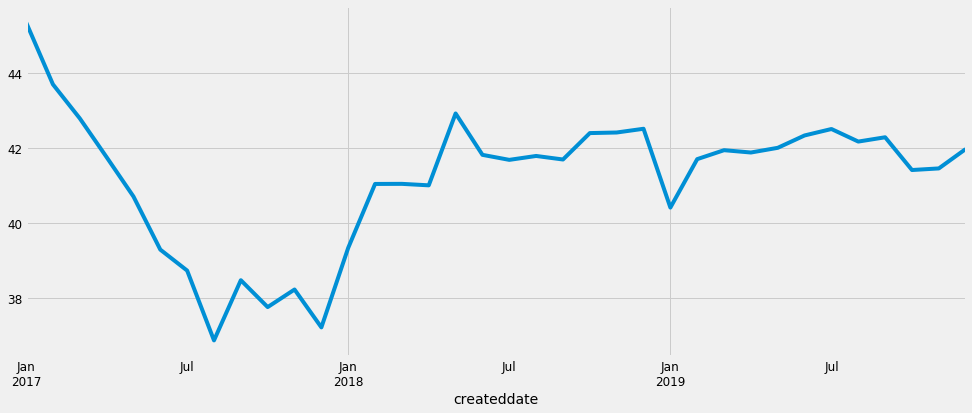

In [172]:
y.plot(figsize=(15, 6))
plt.show()

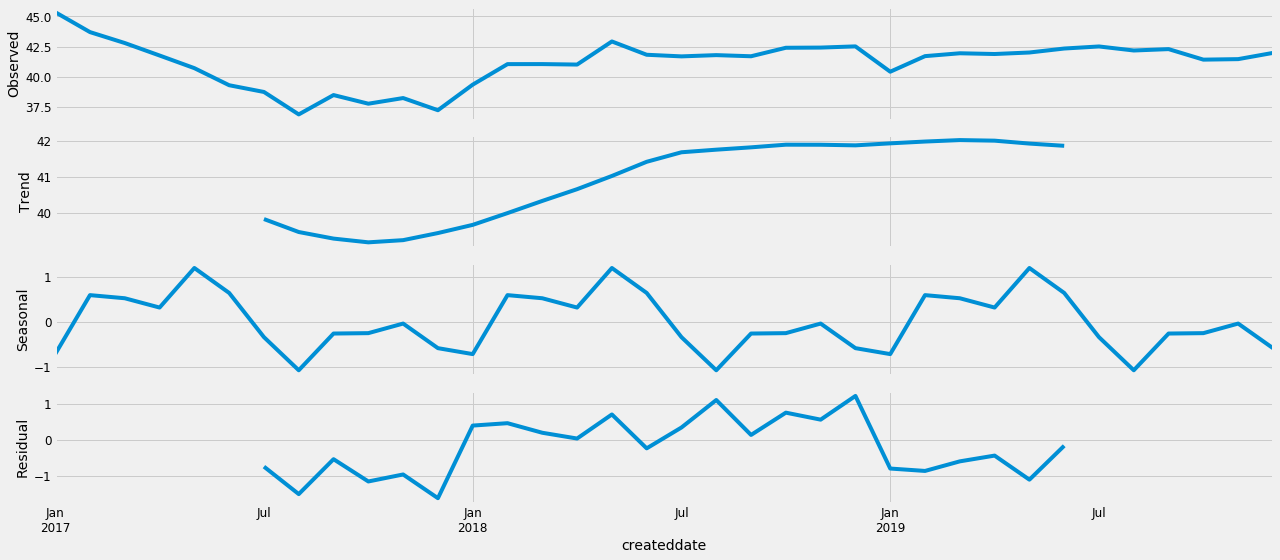

In [173]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [174]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [175]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:361.44627010762747
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:108.83823902519563
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:118.04264822182562
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:29.81758133435741
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:310.78143991257156
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:93.76960355945388


/Users/robblatt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:120.63282003130797
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:29.587250429137793
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:97.92861287727598
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:81.35574298933179
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:57.93450385842515
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:28.599246238808295
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:97.06572797567095
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:80.0603833075218
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:53.92579838850046
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:29.137823314588083
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:104.04388412947819
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:85.2320531672987
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:85.01208951099443
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:28.207322546760107
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:101.5680403832407
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:82.75843530891407
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:87.0050568172694
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:29.286679433096992
ARIMA(

In [176]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2835      0.524      0.541      0.589      -0.744       1.311
ma.L1         -1.0000   8253.906     -0.000      1.000   -1.62e+04    1.62e+04
ar.S.L12      -0.1584      0.085     -1.874      0.061      -0.324       0.007
sigma2         0.4027   3324.311      0.000      1.000   -6515.126    6515.932


ValueError: operands could not be broadcast together with shapes (9,) (8,) (9,) 

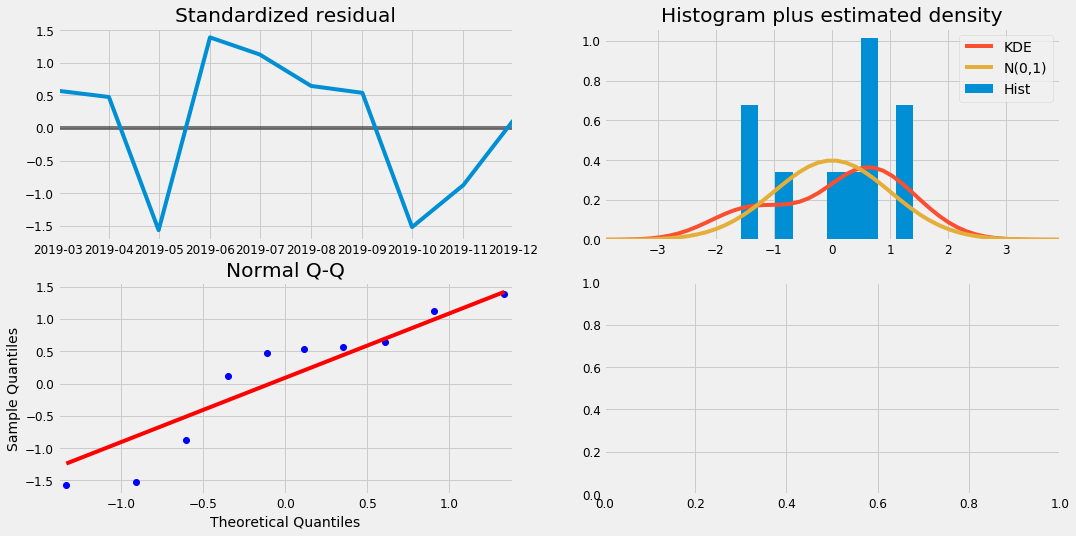

In [177]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

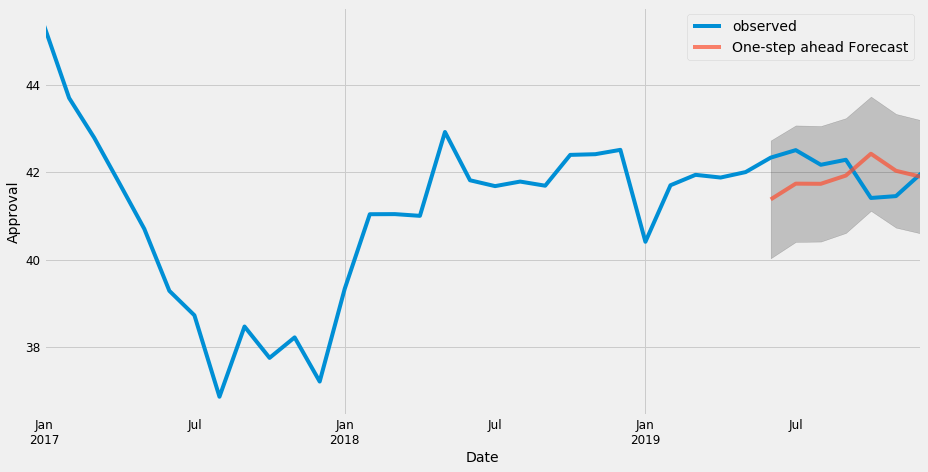

In [178]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Approval')
plt.legend()
plt.show()

In [179]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.46


In [180]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.67


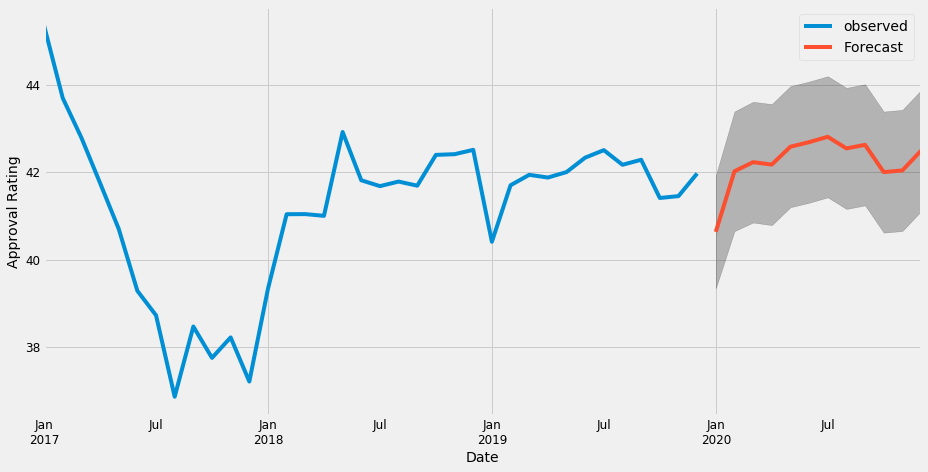

In [183]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Approval Rating')
plt.legend()
plt.show()

In [189]:
approve = df_merged.loc[df_merged['Category'] == 'approve']
disapprove = df_merged.loc[df_merged['Category'] == 'disapprove']
approve.shape, disapprove.shape

((10484, 3), (10484, 3))

In [190]:
approve.head()

,Category,createddate,rating
0,approve,2017-01-23,44.364073
1,approve,2017-01-23,45.850560
2,approve,2017-01-24,45.850560
3,approve,2017-03-01,42.701835
4,approve,2017-03-01,42.901835


In [191]:
approve = approve.sort_values('createddate')
disapprove = disapprove.sort_values('createddate')
approve = approve.groupby('createddate')['rating'].mean().reset_index()
disapprove = disapprove.groupby('createddate')['rating'].mean().reset_index()
approve = approve.set_index('createddate')
disapprove = disapprove.set_index('createddate')
y_approve = approve['rating'].resample('MS').mean()
y_disapprove = disapprove['rating'].resample('MS').mean()
approve = pd.DataFrame({'createddate':y_approve.index, 'rating':y_approve.values})
disapprove = pd.DataFrame({'createddate': y_disapprove.index, 'rating': y_disapprove.values})
merged = approve.merge(disapprove, how='inner', on='createddate')
merged.rename(columns={'rating_x': 'approve_rating', 'rating_y': 'disapprove_rating'}, inplace=True)
merged.head()

,createddate,approve_rating,disapprove_rating
0,2017-01-01,45.355611,-45.450655
1,2017-02-01,43.699464,-50.328439
2,2017-03-01,42.792119,-51.037999
3,2017-04-01,41.756228,-52.158781
4,2017-05-01,40.706615,-53.328678


In [195]:
merged['disapprove_rating'] = merged['disapprove_rating'] * -1

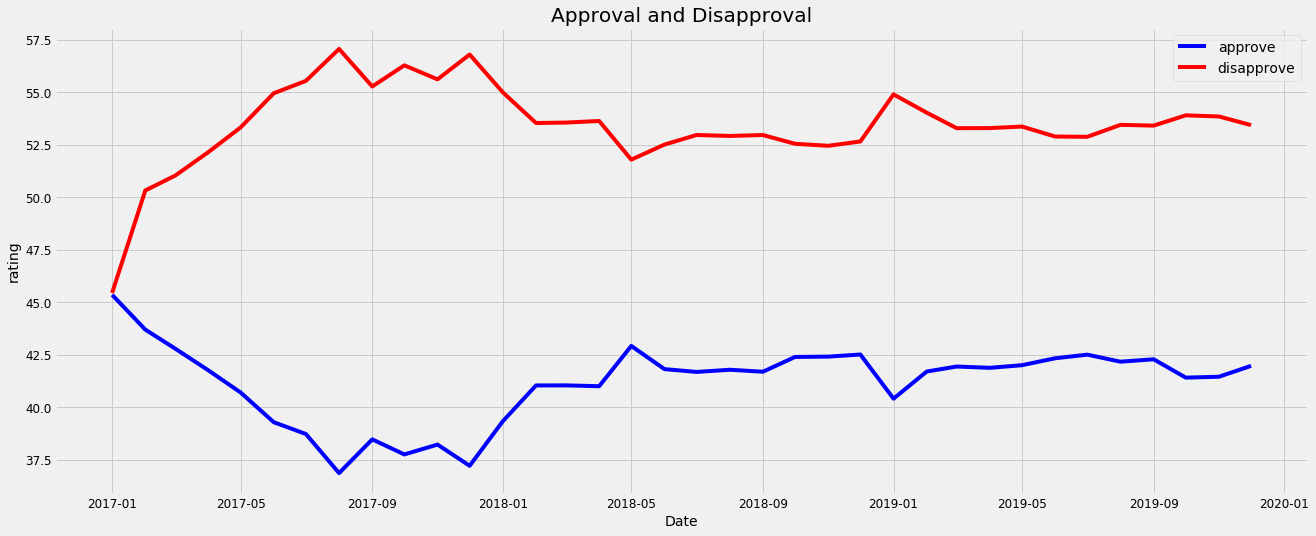

In [197]:
plt.figure(figsize=(20, 8))
plt.plot(merged['createddate'], merged['approve_rating'], 'b-', label = 'approve')
plt.plot(merged['createddate'], merged['disapprove_rating'], 'r-', label = 'disapprove')
plt.xlabel('Date'); plt.ylabel('rating'); 
plt.title('Approval and Disapproval')
plt.legend();

In [228]:
try:
    first_date = merged.ix[np.min(list(np.where(merged['disapprove_rating'] < merged['approve_rating'])[0])), 'createddate']
    print("The first date where approval is higher than disaproval is {}.".format(first_date.date()))
except:
    print("The approval rating has never been higher than the disapproval ratings")

The approval rating has never been higher than the disapproval ratings


In [216]:
disapprove

,ds,y
0,2017-01-01,-45.450655
1,2017-02-01,-50.328439
2,2017-03-01,-51.037999
3,2017-04-01,-52.158781
4,2017-05-01,-53.328678
5,2017-06-01,-54.957943
6,2017-07-01,-55.545996
7,2017-08-01,-57.067315
8,2017-09-01,-55.280734
9,2017-10-01,-56.286736


In [217]:
disapprove['y'] = disapprove['y'] * -1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

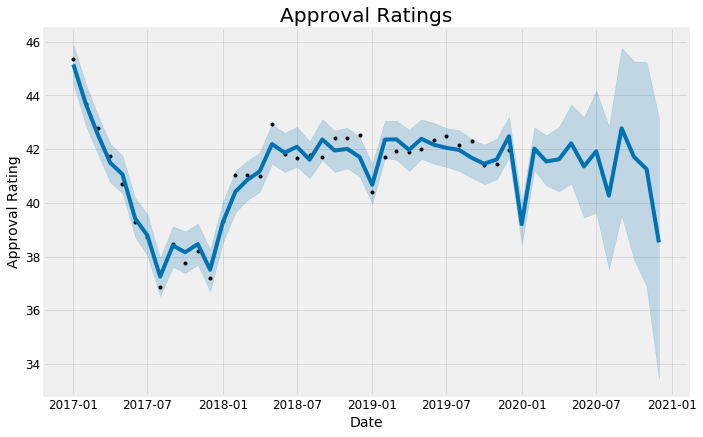

In [218]:
from fbprophet import Prophet
approve = approve.rename(columns={'createddate': 'ds', 'rating': 'y'})
approve_model = Prophet(interval_width=0.95)
approve_model.fit(approve)
disapprove = disapprove.rename(columns={'createddate': 'ds', 'rating': 'y'})
disapprove_model = Prophet(interval_width=0.95)
disapprove_model.fit(disapprove)
approve_forecast = approve_model.make_future_dataframe(periods=12, freq='MS')
approve_forecast = approve_model.predict(approve_forecast)
disapprove_forecast = disapprove_model.make_future_dataframe(periods=12, freq='MS')
disapprove_forecast = disapprove_model.predict(disapprove_forecast)
plt.figure(figsize=(18, 6))
approve_model.plot(approve_forecast, xlabel = 'Date', ylabel = 'Approval Rating')
plt.title('Approval Ratings');

<Figure size 1296x432 with 0 Axes>

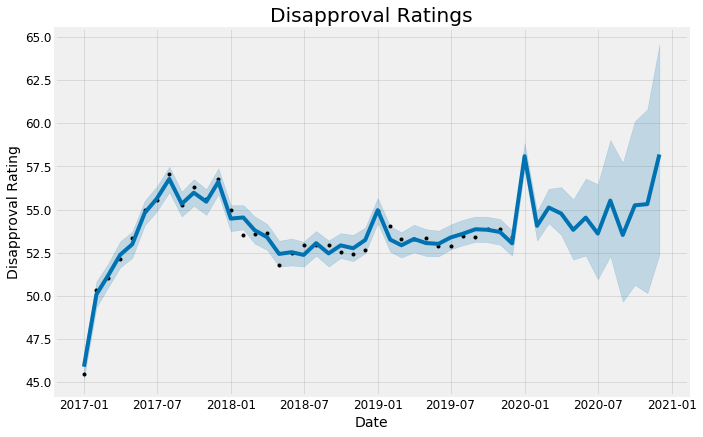

In [219]:
plt.figure(figsize=(18, 6))
disapprove_model.plot(disapprove_forecast, xlabel = 'Date', ylabel = 'Disapproval Rating')
plt.title('Disapproval Ratings');

In [221]:
approve_names = ['approve_%s' % column for column in approve_forecast.columns]
disapprove_names = ['disapprove_%s' % column for column in disapprove_forecast.columns]
merge_approve_forecast = approve_forecast.copy()
merge_disapprove_forecast = disapprove_forecast.copy()
merge_approve_forecast.columns = approve_names
merge_disapprove_forecast.columns = disapprove_names
forecast = pd.merge(merge_approve_forecast, merge_disapprove_forecast, how = 'inner', left_on = 'approve_ds', right_on = 'disapprove_ds')
forecast = forecast.rename(columns={'approve_ds': 'Date'}).drop('disapprove_ds', axis=1)
forecast.head()

,Date,approve_trend,approve_yhat_lower,approve_yhat_upper,approve_trend_lower,approve_trend_upper,approve_additive_terms,approve_additive_terms_lower,approve_additive_terms_upper,approve_yearly,...,disapprove_additive_terms,disapprove_additive_terms_lower,disapprove_additive_terms_upper,disapprove_yearly,disapprove_yearly_lower,disapprove_yearly_upper,disapprove_multiplicative_terms,disapprove_multiplicative_terms_lower,disapprove_multiplicative_terms_upper,disapprove_yhat
0,2017-01-01,44.157873,44.431639,45.889227,44.157873,44.157873,0.997499,0.997499,0.997499,0.997499,...,-2.459076,-2.459076,-2.459076,-2.459076,-2.459076,-2.459076,0.0,0.0,0.0,45.902031
1,2017-02-01,43.124469,42.865038,44.402077,43.124469,43.124469,0.538396,0.538396,0.538396,0.538396,...,0.277017,0.277017,0.277017,0.277017,0.277017,0.277017,0.0,0.0,0.0,50.092841
2,2017-03-01,42.191073,41.861890,43.289555,42.191073,42.191073,0.381173,0.381173,0.381173,0.381173,...,0.012618,0.012618,0.012618,0.012618,0.012618,0.012618,0.0,0.0,0.0,51.142382
3,2017-04-01,41.157669,40.770584,42.205303,41.157669,41.157669,0.339375,0.339375,0.339375,0.339375,...,-0.201258,-0.201258,-0.201258,-0.201258,-0.201258,-0.201258,0.0,0.0,0.0,52.383224
4,2017-05-01,40.157601,40.357491,41.751676,40.157601,40.157601,0.903499,0.903499,0.903499,0.903499,...,-0.998704,-0.998704,-0.998704,-0.998704,-0.998704,-0.998704,0.0,0.0,0.0,52.993570


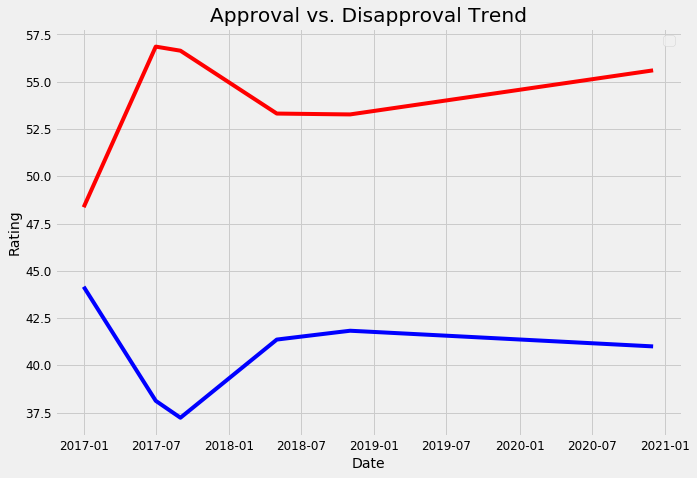

In [223]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['approve_trend'], 'b-')
plt.plot(forecast['Date'], forecast['disapprove_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Rating')
plt.title('Approval vs. Disapproval Trend');

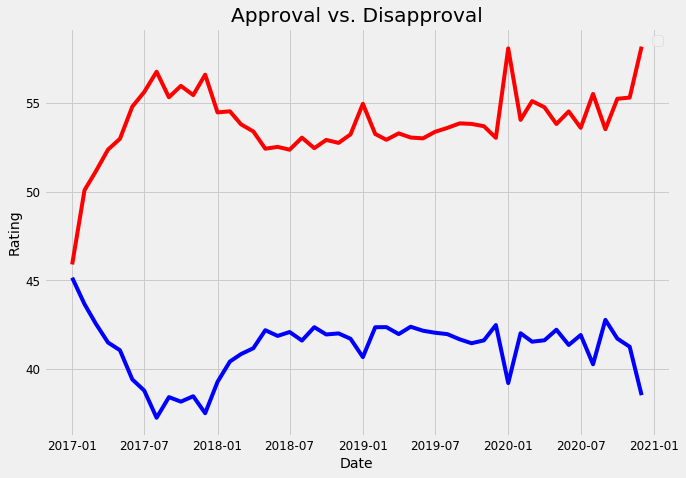

In [224]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['approve_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['disapprove_yhat'], 'r-')
plt.legend();
plt.xlabel('Date');
plt.ylabel('Rating')
plt.title('Approval vs. Disapproval');

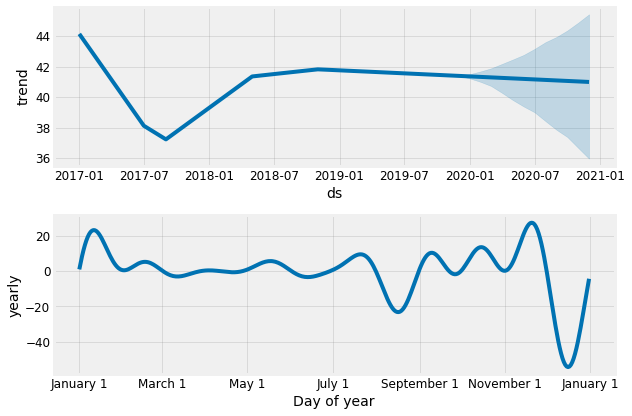

In [225]:
approve_model.plot_components(approve_forecast);

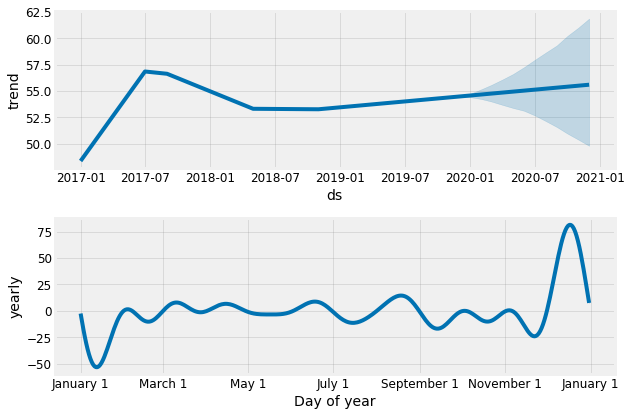

In [226]:
disapprove_model.plot_components(disapprove_forecast);